# Playground to test CAs
### Notes
- The score is a ratio of MSE calculated for CA-based model output and average MSE value caluculated on 10 random samples from the input data.
- Rules are 0-indexed, e.g. 1st rule is 0-th rule according to NMS
- Only even (1-indexed, will be odd for 0-indexed) rule numbers are usable - even rules produce output that cannot be used for the calculations (see images [here](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html) and [here](https://en.wikipedia.org/wiki/Elementary_cellular_automaton#) for reasons why).
- The calculation results appear out of order because they are calculated concurrently on two processors - they appear in "calculations are completed" order, which may not be the same as the order in which they are submitted to processors.
- Simulation runtime:
  - About 26 minutes in free Colab (2 processors + 12Gb RAM).
  - Can be improved by increasing the number of processors - 52 / (num_processors) improvement expected.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#Setup in colab
!pip install cellpylib
!pip install pandas
!pip install scipy
!pip install plotly

In [27]:
import cellpylib as cpl
import pandas as pd
import numpy as np
from random import random
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Download data from https://www.kaggle.com/datasets/htagholdings/property-sales and save to your Google Drive.

In [4]:
# Taking unaggregated time series data
raw_sales = pd.read_csv('/content/drive/MyDrive/raw_sales.csv')

In [28]:
# Exploring
raw_sales.head(10)

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
5,2007-04-04 00:00:00,2905,465000,house,4
6,2007-04-24 00:00:00,2607,399000,house,3
7,2007-04-30 00:00:00,2606,1530000,house,4
8,2007-05-24 00:00:00,2902,359000,house,3
9,2007-05-25 00:00:00,2906,320000,house,3


In [29]:
raw_sales['postcode'].unique()

array([2607, 2906, 2905, 2606, 2902, 2612, 2904, 2615, 2914, 2602, 2600,
       2605, 2603, 2611, 2903, 2617, 2913, 2604, 2614, 2912, 2601, 2900,
       2620, 2618, 2616, 2911, 2609])

In [30]:
raw_sales.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


In [31]:
# Preprocessing
data = raw_sales.copy()
data['datesold'] = pd.to_datetime(data['datesold'], dayfirst=True)
processed_data = data.join(pd.get_dummies(data['propertyType'])).drop(['propertyType', 'postcode'], axis=1)
rs_min_date = processed_data['datesold'].min() #saving for visualization of CA results
processed_data['date_ordinal'] = (processed_data['datesold'] - processed_data['datesold'].min()).dt.days
rs_min_date = processed_data['datesold'].min() #saving for visualization of CA results
processed_data = processed_data.drop('datesold', axis=1)
display(processed_data)
display(processed_data.describe())

,price,bedrooms,house,unit,date_ordinal
0,525000,4,1,0,0
1,290000,3,1,0,20
2,328000,3,1,0,28
3,380000,4,1,0,30
4,310000,3,1,0,42
...,...,...,...,...,...
29575,500000,3,0,1,4551
29576,560000,2,0,1,4551
29577,464950,2,0,1,4552
29578,589000,2,0,1,4552


,price,bedrooms,house,unit,date_ordinal
count,2.958000e+04,29580.000000,29580.000000,29580.000000,29580.000000
mean,6.097363e+05,3.250169,0.830020,0.169980,2936.316464
std,2.817079e+05,0.951275,0.375621,0.375621,1075.529118
min,5.650000e+04,0.000000,0.000000,0.000000,0.000000
25%,4.400000e+05,3.000000,1.000000,0.000000,2190.000000
50%,5.500000e+05,3.000000,1.000000,0.000000,3157.000000
75%,7.050000e+05,4.000000,1.000000,0.000000,3822.000000
max,8.000000e+06,5.000000,1.000000,1.000000,4553.000000


In [32]:
def evolve_data_ga(data, controlled_vars, threshold_values, rule_numbers, num_iterations, rounds, resampling_count=10):
    '''Function to apply CA to filter the data'''
    try:
        dr_data = data.copy()
        for round in range(rounds):
            vector = dr_data[controlled_vars[round]].to_numpy()
            thresholds = lambda x: 0 if x < threshold_values[round] else 1
            ca_input = np.array([list(map(thresholds, vector))])
            cellular_automaton = cpl.evolve(ca_input, timesteps=num_iterations[round], memoize=True,
                                            apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_numbers[round]))
            mask = cellular_automaton[-1,:]
            dim_red_data = dr_data.iloc[mask.astype(bool)]
            dr_data = dim_red_data

        # Prepare features and target variable for dimensionality-reduced data
        X = dr_data.drop(['price'], axis=1)
        y = dr_data['price']
        split_point = int(len(dr_data) * 0.8)
        X_train = X[:split_point]
        y_train = y[:split_point]
        X_test = X[split_point:]
        y_test = y[split_point:]

        # Train and evaluate the model on dimensionality-reduced data
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse_dim_red = mean_squared_error(y_test, predictions)

        # Randomly sample rows from the original dataset
        mse_random = 0
        for _ in range(resampling_count):
          data_random_sample = data.sample(n=len(dr_data))
          X_random = data_random_sample.drop(['price'], axis=1)
          y_random = data_random_sample['price']
          X_train_random = X_random[:split_point]
          y_train_random = y_random[:split_point]
          X_test_random = X_random[split_point:]
          y_test_random = y_random[split_point:]

          # Train and evaluate the model on randomly sampled data
          model_random = LinearRegression()
          model_random.fit(X_train_random, y_train_random)
          predictions_random = model_random.predict(X_test_random)
          mse_random += mean_squared_error(y_test_random, predictions_random)/resampling_count

        # Calculate the MSE ratio
        mse_ratio = mse_dim_red / mse_random if mse_random != 0 else np.inf

    except ValueError as e:
        mse_ratio = 1e1000

    return dr_data, sum([threshold_values, rule_numbers, num_iterations], []), mse_ratio


In [33]:
# Testing the function
rounds = 3
evolved_data = evolve_data_ga(
    data = processed_data,
    controlled_vars = ['date_ordinal']*rounds,
    threshold_values = [1506]*rounds,
    rule_numbers = [30]*rounds,
    num_iterations = [198]*rounds,
    rounds = rounds
    )
evolved_data

(        price  bedrooms  house  unit  date_ordinal
 4      310000         3      1     0            42
 30     520000         4      1     0           174
 43     560000         4      1     0           197
 61     500000         4      1     0           227
 66     475000         3      1     0           237
 ...       ...       ...    ...   ...           ...
 29553  250000         1      0     1          4543
 29559  560000         3      0     1          4544
 29562  310000         1      0     1          4549
 29564  450000         3      0     1          4549
 29571  297500         2      0     1          4551
 
 [210 rows x 5 columns],
 [1506, 1506, 1506, 30, 30, 30, 198, 198, 198],
 0.2144901581733227)

In [34]:
def evaluate_parameters(params, data, rounds):
    thv, rn, ni = params
    threshold_values = [thv] * rounds
    rule_numbers = [rn] * rounds
    num_iterations = [ni] * rounds
    try:
        output = evolve_data_ga(
            data=data,
            controlled_vars=['date_ordinal'] * rounds,
            threshold_values=threshold_values,
            rule_numbers=rule_numbers,
            num_iterations=num_iterations,
            rounds=rounds
        )

        fitness = output[-1]

        return fitness, threshold_values, rule_numbers, num_iterations
    except ValueError as e:
        return np.inf, threshold_values, rule_numbers, num_iterations

In [35]:
def custom_cross_validation_sequential(data, rounds, controlled_var, threshold_value, num_iterations, rules_to_check=256):
    rule_numbers_range = list(range(rules_to_check))  # Sequentially iterating over rule numbers 0 to 255

    scores = []  # To store the fitness scores
    evaluated_rule_numbers = []  # To store the evaluated rule numbers

    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(evaluate_parameters, (threshold_value, rn, num_iterations), data, rounds): rn for rn in rule_numbers_range if rn%2 != 0}

        for future in as_completed(futures):
            rn = futures[future]  # Get the rule number for this future
            try:
                fitness, _, _, _ = future.result()
                scores.append(fitness)
                evaluated_rule_numbers.append(rn)
                print(f'Finished calculation for Rule Number {rn}: {fitness}')
            except Exception as exc:
                print(f'Rule number {rn} generated an exception: {exc}')

    # Find the best score and corresponding rule number
    best_score = min(scores) if scores else np.inf
    best_rule_number = evaluated_rule_numbers[scores.index(best_score)] if scores else None
    best_params = (threshold_value, best_rule_number, num_iterations) if best_rule_number is not None else None
    print(f'Best Score: {best_score}, Best Params: {best_params}')

    # Plotting the scores for each rule number using Plotly
    fig = go.Figure(data=[go.Bar(
        x=evaluated_rule_numbers,
        y=scores,
        text=scores,
        marker_color='blue',
        hoverinfo='x+y'
    )])

    fig.update_layout(
        title_text='Fitness Score for Each Rule Number',
        xaxis_title='Rule Number',
        yaxis_title='Fitness Score',
        bargap=0.2,
    )

    fig.add_trace(go.Scatter(x=[best_rule_number], y=[best_score],
                             mode='markers', marker_symbol='star', marker_size=15,
                             marker_color='red', name='Best Score',
                             hovertext=f"Rule Number: {best_rule_number}, Score: {best_score}"))

    fig.show()

    return best_params, best_score


In [36]:
# Hyperparameters
# Number of rounds to repeat application of CA to the data
rounds = 3
# Controlled variable
contr_var = 'price'
# Cellular automata (CA) threshold
th_val = 1_000_000
# Number of iterations of CA
ca_it_num = 200
# Number of rule up to which to check (rules are 0-indexed)
rules_to_check = 256

In [37]:
best_params, best_score = custom_cross_validation_sequential(
    data = processed_data,
    rounds = rounds,
    controlled_var = contr_var,
    threshold_value = th_val,
    num_iterations = ca_it_num,
    rules_to_check = rules_to_check
    )
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Finished calculation for Rule Number 1: 0.5170700657871726
Finished calculation for Rule Number 3: 0.5170700657871726
Finished calculation for Rule Number 5: 0.5539352579509162
Finished calculation for Rule Number 7: 0.5539352579509162
Finished calculation for Rule Number 9: 0.5290631830793944
Finished calculation for Rule Number 11: 0.5290631830793944
Finished calculation for Rule Number 13: 0.5354097334532388
Finished calculation for Rule Number 15: 0.5354097334532388
Finished calculation for Rule Number 17: 0.5207699549780751
Finished calculation for Rule Number 19: 0.5207699549780751
Finished calculation for Rule Number 21: 0.5027138058227779
Finished calculation for Rule Number 23: 0.5027138058227779
Finished calculation for Rule Number 25: 0.5218629568527338
Finished calculation for Rule Number 27: 0.5218629568527338
Finished calculation for Rule Number 29: 0.5280632520022543
Finished calculation for Rule Number 31: 0.5280632520022543
Finished calculation for Rule Number 33: 0.51

Best Parameters: (1000000, 201, 200)
Best Score: 0.48149477376475386


In [38]:
evolved_data = evolve_data_ga(
    data = processed_data,
    controlled_vars = ['price']*rounds,
    threshold_values = [best_params[0]]*rounds,
  rule_numbers = [best_params[1]]*rounds,
    num_iterations = [best_params[2]]*rounds,
    rounds = rounds
    )[0]

In [39]:
# Testing regression performance
# Prepare features and target variable
X = evolved_data.drop(['price'], axis=1)  # Features
y = evolved_data['price']  # Target variable


# Assuming you want to use the first 80% of the data for training and the rest for testing
split_point = int(len(evolved_data) * 0.8)
training_data = evolved_data[:split_point]
testing_data = evolved_data[split_point:]

# Prepare features and target variable for training and testing sets
X_train = training_data.drop(['price'], axis=1)
y_train = training_data['price']
X_test = testing_data.drop(['price'], axis=1)
y_test = testing_data['price']

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 41421732830.01218
R-squared: 0.31433173979338913


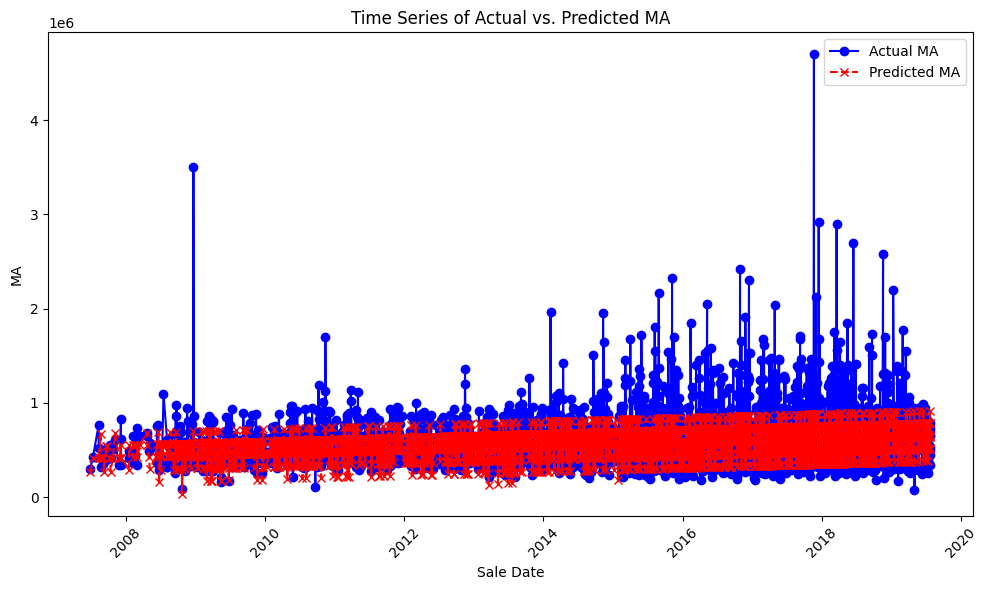

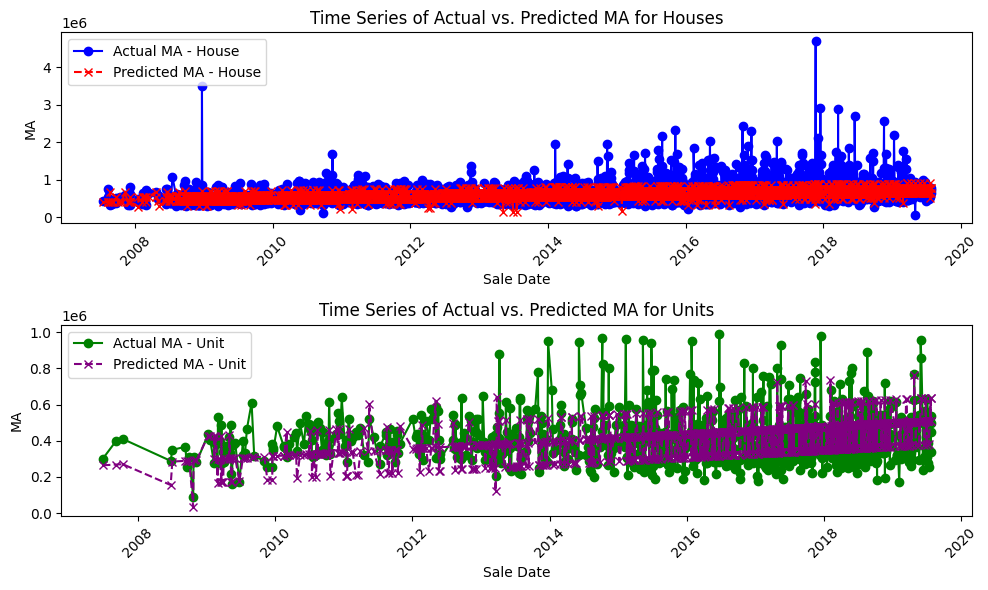

In [40]:
# First, we need to recover the actual sale dates from `date_ordinal`
X_test_sorted = X_test.copy()
X_test_sorted['predictions'] = predictions

# Convert `date_ordinal` back to datetime for plotting
X_test_sorted['saledate'] = pd.to_timedelta(X_test_sorted['date_ordinal'], unit='D') + rs_min_date

# Now sort by `saledate`
X_test_sorted.sort_values('saledate', inplace=True)

# Recover the actual MA values for the sorted test set
actual_MA_sorted = y_test.reindex(X_test_sorted.index)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted['saledate'], actual_MA_sorted, label='Actual MA', color='blue', marker='o')
plt.plot(X_test_sorted['saledate'], X_test_sorted['predictions'], label='Predicted MA', color='red', linestyle='--', marker='x')

plt.title('Time Series of Actual vs. Predicted MA')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()

# Separate data for 'house' and 'unit'
house_data = X_test_sorted[X_test_sorted['house'] == 1]
unit_data = X_test_sorted[X_test_sorted['unit'] == 1]

# Recover the actual MA values for 'house' and 'unit'
actual_MA_house = y_test.reindex(house_data.index)
actual_MA_unit = y_test.reindex(unit_data.index)

# Plotting
plt.figure(figsize=(10, 6))

# Plot for 'house'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(house_data['saledate'], actual_MA_house, label='Actual MA - House', color='blue', marker='o')
plt.plot(house_data['saledate'], house_data['predictions'], label='Predicted MA - House', color='red', linestyle='--', marker='x')
plt.title('Time Series of Actual vs. Predicted MA for Houses')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)

# Plot for 'unit'
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(unit_data['saledate'], actual_MA_unit, label='Actual MA - Unit', color='green', marker='o')
plt.plot(unit_data['saledate'], unit_data['predictions'], label='Predicted MA - Unit', color='purple', linestyle='--', marker='x')
plt.title('Time Series of Actual vs. Predicted MA for Units')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()